In [21]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss

#### Categorias do Documento  
Como explicado na documentação, os textos são divididos em algumas categorias. Para processar os dados, deve-se converter essas strings em números.  
É importante lembrar que antes de executar o programa deve-se descompactar o arquivo *rcv1rcv2aminigoutte.tar.gz* na pasta do projeto. Isso criará a pasta *rcv1rcv2aminigoutte*, que contém os arquivos necessários para o problema.

In [2]:
categories = {'C15': 4587, 'CCAT': 8745, 'E21': 9625, 'ECAT': 5656, 'GCAT': 5745, 'M11': 45845}

Esse método faz esse tratamento dos dados, substituindo as strings correspondentes as classes em seus respectivos números.

In [3]:
def filter_datas(file, target_file):
    with open(file, 'r') as document_read:
        with open(target_file, 'w') as document_write:
            for line in document_read:
                target = line.split(None, 1)[0]
                line_to_write = '%s %s' % (categories[target], line[len(target)+1:len(line)])
                document_write.write(line_to_write)
        
    return target_file

#### Carregando o dataset no formato SVMLight

In [4]:
file = filter_datas('rcv1rcv2aminigoutte/EN/Index_EN-EN', 'svml_en_en.txt')
X,  y = load_svmlight_file(file)

#### Aplicando a seleção das features

In [5]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

In [6]:
print('Data matrix shape before feature selection: ' + str(X.shape))
print('Data matrix shape after feature selection: ' + str(X_new.shape))

Data matrix shape before feature selection: (18758, 21531)
Data matrix shape after feature selection: (18758, 3005)


## Avaliando os Modelos

#### Dividindo o dataset
O método *train_test_split* é bem útil para dividir os dados em partes que serão usados para o treino do modelo e os testes, que serão convenientes para avaliar o modelo. Os dados de treino estarão em *x_train* e *y_train*, e os dados de teste em *x_test* e *y_test*, sendo que 25% dos dados serão usados para os testes e os outros 75% para o treinamento.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [8]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Treinando o modelo
O treino dos dados é feito pelo método *fit*, e após isso é utilizado o método *predict* para fazer a predição do modelo. Nesse caso também está sendo aferido o tempo de execução do algoritmo para ser comparado entre os dois classificadores que foram utilizados.

**SVC** - Tem sua implementação baseada no *libsvm*, que é um software integrado para suporte de vetores de classificação, regressão e estimativa de distribuição, além de suportar classificação de multi-classes. O grande problema dele sua complexidade, que por ser maior que o quadrado das amostras, torna ele plausível para pouco mais de 10000 amostras 

In [19]:
%%time
svc = SVC()
svc.fit(X_train, y_train)
y_pred_SVC = svc.predict(X_test)

CPU times: user 2min 9s, sys: 484 ms, total: 2min 10s
Wall time: 2min 10s


#### Matriz de confusão
A matriz de confusão (ou matriz de erro) é bastante utilizada em problemas de classificação, pois permite vizualizar a performance do algoritmo. Para isso, são utilizadas as observações previstas em um grupo conhecido *i*, mas que foram previstos em um grupo *j*, ou seja, relaciona os valores reais com os previstos pelo classificador.

In [10]:
class_as_number = [4587, 8745, 9625, 5656, 5745, 45845]
confusion_SVC = confusion_matrix(y_test, y_pred_SVC, labels=class_as_number)

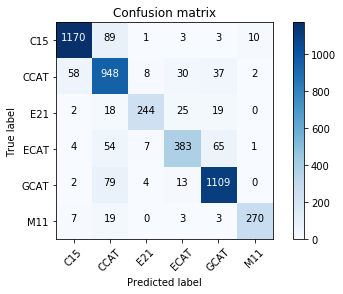

In [11]:
class_as_string = ['C15', 'CCAT', 'E21', 'ECAT', 'GCAT', 'M11']

plt.figure() 
plot_confusion_matrix(confusion_SVC, classes=class_as_string)

plt.show()

#### Relatório de classificação
Provê algumas métricas também sobre a performance do algoritmo, que são:
- *Precisão*: busca relacionar, de todas as predições que foram classificadas como sendo de determinada classe, quais realmente eram. Ĺogo, sua fórmula é o quociente entre as predições corretas sobre a soma das predições corretas e as .
- *Recall*: é a frequência em que uma classe é classificada, porém quantas vezes ela foi classificada  corretamente. Assim, sua fórmula é o quociente entre as predições corretas de uma classe *x* sobre a soma entre as predições corretas da classe *x* e as predições de outras classes que preveram erroneamente a classe *x*.
- *F1 Score*: combina a precisão e o recall, gerando uma métrica que indica a qualidade geral do modelo. Sua fórmula é o quociente do dobro do produto da precisão e do recall sobre a soma da precisão e do recall.

In [12]:
report_SVC = classification_report(y_test, y_pred_SVC, labels=class_as_number, target_names=class_as_string)
print(report_SVC)

             precision    recall  f1-score   support

        C15       0.94      0.92      0.93      1276
       CCAT       0.79      0.88      0.83      1083
        E21       0.92      0.79      0.85       308
       ECAT       0.84      0.75      0.79       514
       GCAT       0.90      0.92      0.91      1207
        M11       0.95      0.89      0.92       302

avg / total       0.88      0.88      0.88      4690



#### Perda de Hamming
Computa a porcentagem de média de erro do modelo, ou seja, os dados que foram classificados de maneira incorreta, sendo assim sua fórmula seria o quociente das previsões incoretas sobre todas as previsões.

In [26]:
hammig_loss_svc = hamming_loss(y_test, y_pred_SVC) * 100
print("Hamming Loss = %f" % hammig_loss_svc)

Hamming Loss = 12.068230


**LinearSVC** - É similar ao SVC, porém ele é implementado nos termos do *liblinear*, que consegue ser mais eficiente que o *libsvm* para datasets muito grandes, com milhões de dados.

In [13]:
%%time
linear_SVC = LinearSVC(random_state=0)
linear_SVC.fit(X_train, y_train)
y_pred_linearSVC = linear_SVC.predict(X_test)

CPU times: user 5.43 s, sys: 4.02 ms, total: 5.43 s
Wall time: 5.43 s


#### Matriz de confusão

In [14]:
confusion_linearSVC = confusion_matrix(y_test, y_pred_linearSVC, labels=class_as_number)

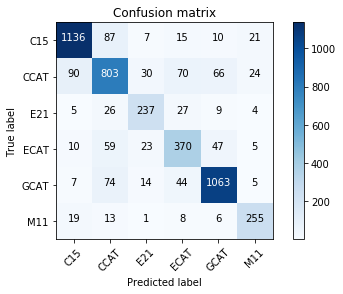

In [15]:
plt.figure() 
plot_confusion_matrix(confusion_linearSVC, classes=class_as_string)

plt.show()

#### Relatório de classificação

In [17]:
report_linearSVC = classification_report(y_test,
                                         y_pred_linearSVC,
                                         labels=class_as_number, 
                                         target_names=class_as_string)
print(report_linearSVC)

             precision    recall  f1-score   support

        C15       0.90      0.89      0.89      1276
       CCAT       0.76      0.74      0.75      1083
        E21       0.76      0.77      0.76       308
       ECAT       0.69      0.72      0.71       514
       GCAT       0.89      0.88      0.88      1207
        M11       0.81      0.84      0.83       302

avg / total       0.82      0.82      0.82      4690



#### Perda de Hamming

In [28]:
hammig_loss_linear_svc = hamming_loss(y_test, y_pred_linearSVC) * 100
print("Hamming Loss = %f" % hammig_loss_linear_svc)

Hamming Loss = 17.611940
